In [42]:
import numpy as np
from surface_code import SurfaceCode
import matplotlib as mpl
import seaborn as sns

Ls = [3,5,7]
ps = np.linspace(0, 0.01, 6)

results = {}

for L in Ls:
    SC = SurfaceCode(distance=L)
    res_L = []
    for p in ps:
        SC.build_in_stim(rounds=L, depolarize_prob=p)
        ler = SC.run_with_pymatching(shots=10000)
        res_L.append(ler)
    results[L] = np.array(res_L)

    import matplotlib.pyplot as plt

    # Apply scientific plot styling
    sns.set_style("darkgrid")
    mpl.rcParams.update(
        {
            "font.size": 12,
            "grid.color": "0.5",
            "grid.linestyle": "--",
            "grid.linewidth": 0.6,
            "xtick.color": "black",
            "ytick.color": "black",
        }
    )

    # Create the plot
    plt.figure(figsize=(10, 6))

    for L, lers in results.items():
        plt.plot(ps, lers, marker='o', linestyle='-', label=f'Distance L={L}')

    # Set plot labels and title
    plt.xlabel("Physical Error Probability (p)")
    plt.ylabel("Logical Error Rate (LER)")
    plt.title("Surface Code Performance")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

ValueError: The circuit contains non-deterministic observables.

To make an SVG picture of the problem, you can use the python API like this:
    your_circuit.diagram('detslice-with-ops-svg', tick=range(0, 9), filter_coords=['L0', ])
or the command line API like this:
    stim diagram --in your_circuit_file.stim --type detslice-with-ops-svg --tick 0:9 --filter_coords L0 > output_image.svg

This was discovered while analyzing a Z-basis reset (R) on:
    qubit 11 [coords (1.5, 1.5)]

The collapse anti-commuted with these detectors/observables:
    L0

The backward-propagating error sensitivity for L0 was:
    X11 [coords (1.5, 1.5)]
    Z15 [coords (2, 2)]

Circuit stack trace:
    during TICK layer #5 of 6
    at instruction #57 [which is R 5 16 0 11 4 10 6 12]

Round 1 (Raw): [ True False  True False  True  True  True False False False  True  True
 False False False False False False False False False False False False]
Round 2 (Raw): [ True False  True False  True  True  True False False False  True  True
 False False False False False False False False False False False False]
Round 3 (Raw): [ True False  True False  True  True  True False False False  True  True
 False False False False False False False False False False False False]
Round 4 (Raw): [ True False  True False  True  True  True False False False  True  True
 False False False False False False False False False False False False]
Syndrome (1-2 Diff): [False False False False False False False False False False False False
 False False False False False False False False False False False False]
Syndrome (1-3 Diff): [False False False False False False False False False False False False
 False False False False False False False False False False False False]
Syndrome (1-4 Di

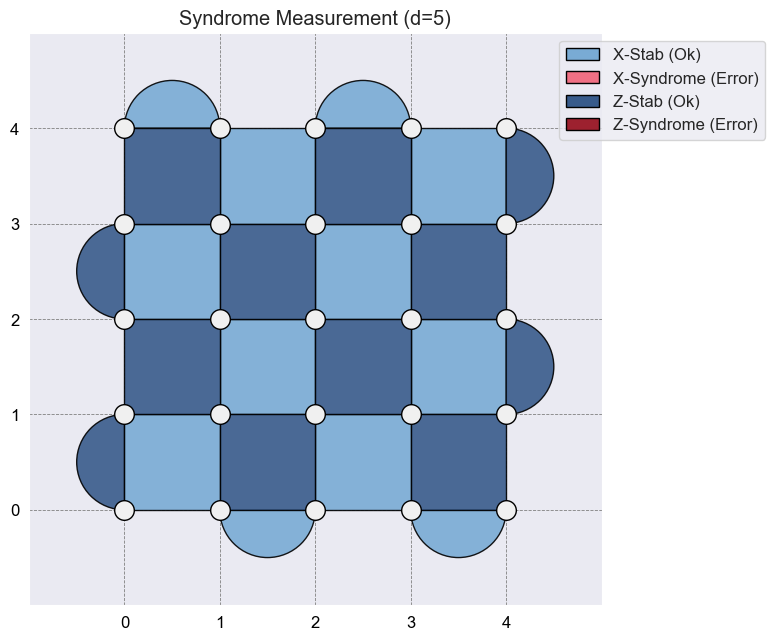

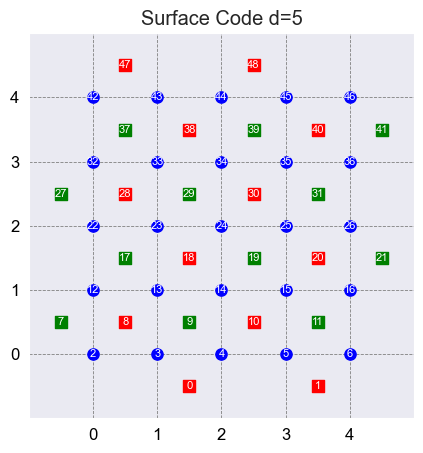

      /----------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\               /-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------\ /----------------------------------------------------------------------\
 q0: -QUBIT_COORDS(1.5,-0.5)---R-----------------

In [40]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)
sc.build_in_stim(rounds=4, depolarize_prob=0.02)

results = sc.run_simulation(shots=1)
single_shot = results[0]

# Calculate number of ancillas
num_ancillas = len(sc.x_stabilisers_coords) + len(sc.z_stabilisers_coords)

# Split results into rounds
round_1 = single_shot[:num_ancillas]
round_2 = single_shot[num_ancillas:2*num_ancillas]
round_3 = single_shot[2*num_ancillas:3*num_ancillas]
round_4 = single_shot[3*num_ancillas:4*num_ancillas]

syndrome_change = round_1 ^ round_2

print("Round 1 (Raw):", round_1)
print("Round 2 (Raw):", round_2)
print("Round 3 (Raw):", round_3)
print("Round 4 (Raw):", round_4)
print("Syndrome (1-2 Diff):", syndrome_change)
print("Syndrome (1-3 Diff):", round_1^round_3)
print("Syndrome (1-4 Diff):", round_1^round_4)

# Visualize the CHANGE, not the raw round
sc.visualize_results(round_1^round_2, show_ancillas=False)
sc.plot()
sc.diagram()

0 (1.5, -0.5) X_stab -> [(2.0, 0.0), (1.0, 0.0)]
inverse mapping: [(2.0, 0.0), (1.0, 0.0)] -> [4, 3]

1 (3.5, -0.5) X_stab -> [(4.0, 0.0), (3.0, 0.0)]
inverse mapping: [(4.0, 0.0), (3.0, 0.0)] -> [6, 5]

7 (-0.5, 0.5) Z_stab -> [(0.0, 1.0), (0.0, 0.0)]
inverse mapping: [(0.0, 1.0), (0.0, 0.0)] -> [12, 2]

8 (0.5, 0.5) X_stab -> [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)]
inverse mapping: [(1.0, 1.0), (0.0, 1.0), (1.0, 0.0), (0.0, 0.0)] -> [13, 12, 3, 2]

9 (1.5, 0.5) Z_stab -> [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)]
inverse mapping: [(2.0, 1.0), (2.0, 0.0), (1.0, 1.0), (1.0, 0.0)] -> [14, 4, 13, 3]

10 (2.5, 0.5) X_stab -> [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)]
inverse mapping: [(3.0, 1.0), (2.0, 1.0), (3.0, 0.0), (2.0, 0.0)] -> [15, 14, 5, 4]

11 (3.5, 0.5) Z_stab -> [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)]
inverse mapping: [(4.0, 1.0), (4.0, 0.0), (3.0, 1.0), (3.0, 0.0)] -> [16, 6, 15, 5]

17 (0.5, 1.5) Z_stab -> [(1.0, 2.0), (1.0, 1.0), (0.0, 2.0), (0

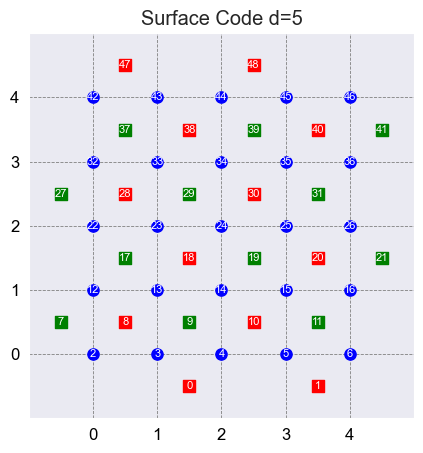

Sorted stabilizers:
8 ((0.5, 0.5), 'X_stab')
28 ((0.5, 2.5), 'X_stab')
47 ((0.5, 4.5), 'X_stab')
0 ((1.5, -0.5), 'X_stab')
18 ((1.5, 1.5), 'X_stab')
38 ((1.5, 3.5), 'X_stab')
10 ((2.5, 0.5), 'X_stab')
30 ((2.5, 2.5), 'X_stab')
48 ((2.5, 4.5), 'X_stab')
1 ((3.5, -0.5), 'X_stab')
20 ((3.5, 1.5), 'X_stab')
40 ((3.5, 3.5), 'X_stab')
7 ((-0.5, 0.5), 'Z_stab')
27 ((-0.5, 2.5), 'Z_stab')
17 ((0.5, 1.5), 'Z_stab')
37 ((0.5, 3.5), 'Z_stab')
9 ((1.5, 0.5), 'Z_stab')
29 ((1.5, 2.5), 'Z_stab')
19 ((2.5, 1.5), 'Z_stab')
39 ((2.5, 3.5), 'Z_stab')
11 ((3.5, 0.5), 'Z_stab')
31 ((3.5, 2.5), 'Z_stab')
21 ((4.5, 1.5), 'Z_stab')
41 ((4.5, 3.5), 'Z_stab')
Data qubits: [2, 3, 4, 5, 6, 12, 13, 14, 15, 16, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 42, 43, 44, 45, 46]


In [4]:
from surface_code import SurfaceCode
sc = SurfaceCode(distance=5)

# Build circuit for 2 rounds to allow comparison
sc.build_in_stim(rounds=4)
all_ids = list(sc.index_mapping.keys())

for anc in all_ids:
    coord, qtype = sc.index_mapping[anc]
    if qtype == 'data':
        continue
    neigh = sc.get_surrounding_data_qubits(coord)
    print(anc, coord, qtype, '->', neigh)
    sc.inverse_mapping
    print(f"inverse mapping: {neigh} -> {[sc.inverse_mapping[n] for n in neigh]}\n")

sc.plot()

print("Sorted stabilizers:")
stab_indices = sc.get_stabilisers(_as="idx") # type: ignore
        
stab_indices = sorted(  # otherwise Z and X stabilizers are measured in random order!
    stab_indices,
    key=lambda anc: (
        sc.index_mapping[anc][1],        # 'X_stab' or 'Z_stab'
        sc.index_mapping[anc][0][0],     # x-coordinate
        sc.index_mapping[anc][0][1],     # y-coordinate
    )
)
for anc in stab_indices:
    print(anc, sc.index_mapping[anc])

data_indices = [k for k, v in sc.index_mapping.items() if v[1] == 'data']
print("Data qubits:", data_indices)


In [ ]:
from surface_code import SurfaceCode
print("--- Initializing SurfaceCode(distance=3) ---")
sc = SurfaceCode(distance=3)

test_instructions = [
    # ---------------------------
    # VALID INSTRUCTIONS
    # ---------------------------
    
    # 1. Standard Single Qubit Gate (Coordinates)
    # Applying H to data qubit at (0,0) and (1,0)
    {'operation': 'H', 'qubits': [(0, 0), (1, 0)]},

    # 2. Standard Single Qubit Gate (Indices)
    # Applying X to qubit index 0 and 2
    {'operation': 'X', 'qubits': [0, 2]},

    # 3. The 'all' keyword
    # Applying Z to all data qubits
    {'operation': 'Z', 'qubits': 'all'},

    # 4. CNOT with Coordinates
    # Control: (0,0), Target: (0,1)
    {'operation': 'CNOT', 'qubits': [((0, 0), (0, 1))]},

    # 5. CNOT with Indices
    # Control: Index 0, Target: Index 1
    {'operation': 'CNOT', 'qubits': [(0, 1)]},

    # 6. Ancilla Interaction (Float Coordinates)
    # Applying X to an ancilla at (0.5, 0.5)
    {'operation': 'X', 'qubits': [(0.5, 0.5)]},

    # ---------------------------
    # INVALID / MIXED INSTRUCTIONS (Should trigger Warnings)
    # ---------------------------

    # 7. Mixed Valid and Invalid Coordinates
    # (0,0) is valid. (99,99) is out of bounds. 
    # Result: Should save (0,0) and warn about (99,99).
    {'operation': 'H', 'qubits': [(0, 0), (99, 99)]},

    # 8. Mixed Valid and Invalid Indices
    # 0 is valid. 1000 is out of bounds.
    {'operation': 'Y', 'qubits': [0, 1000]},

    # 9. Misconception "invalid" CNOT Structure (Missing Target) but correctly formatted
    # Passed a single tuple instead of a tuple of tuples, but 0,0 are valid indices.
    # Result: Save 0,0, no warning, since it's valid.
    {'operation': 'CNOT', 'qubits': [(0, 0)]}, 

    # 10. Invalid CNOT Coordinates
    # One qubit is valid (0,0), one is invalid (99,99). 
    # The whole pair should be skipped.
    {'operation': 'CNOT', 'qubits': [((0, 0), (99, 99))]},
]

print("\n--- Running parse_instructions_new ---")
sc.parse_instructions_new(test_instructions)

print("\n--- Testing Fatal Error (Bad Operation Name) ---")
try:
    # This should raise an Assertion Error immediately
    sc.parse_instructions_new([{'operation': 'MAGIC_GATE', 'qubits': [(0,0)]}])
except AssertionError as e:
    print(f"Caught expected error: {e}")

print("\n--- FINAL PARSED INSTRUCTIONS ---")
for i, instr in enumerate(sc.instructions):
    print(f"{i}: Op: {instr['operation']} | Qubits: {instr['qubits']}")